# Deep Learning Project: Pet Classifier using CNN


Data Set
- A production grade program as 10,000 training images
- This is a small program with 20 images of cats and 20 images of dogs. 
- The evaluation set has 10 images of cats and 10 images of dogs



### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [35]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='./data/train'
testpath='./data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=1000#Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


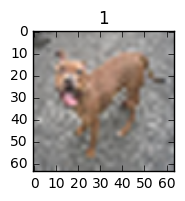

In [36]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[5],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[5])
plt.show()

###  Define the tensorflow model

The model have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training define the loss function and minimize it
- For evaluation calculate the accuracy


### The cnn_model_fn has to be defined here by the student

In [37]:
def cnn_model_fn(features, labels, mode):

     #Please define Input layer
    #Just a reshape of features["x"]
    input_layer = tf.reshape( features["x"], [-1, img_size, img_size, num_channels])
    
    # Then, please define conv1 layer 32 filters with 5X5 size
    # you can use tf.layers.conv2d
    convolutionL1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[5,5],
                                     padding="SAME",activation = tf.nn.relu)
    #Lets define the pooling layer
    poolingL1 = tf.layers.max_pooling2d(inputs=convolutionL1, pool_size=[2,2],
                                       strides=2)
    
    # Conv layer 2 with 64 FILTERS of 5X5 size
    convolutionL2 = tf.layers.conv2d(inputs=poolingL1, filters=64, kernel_size=[5,5],
                                     padding="SAME",activation = tf.nn.relu)
    
# Pooling layer2
    poolingL2 = tf.layers.max_pooling2d(inputs=convolutionL2, 
                                        pool_size=[2,2],
                                       strides=2)
   
    #lets faltten pooling layer
    layer_shape = poolingL2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    poolingL2_flat = tf.reshape(poolingL2,[-1,num_features])

    # Fully connected layer
    fullyconnectedLayer = tf.layers.dense(inputs=poolingL2_flat, units = fc_size, activation=tf.nn.relu)
    #Dropout layer with dropout probability of 0.4
    dropoutlayer = tf.layers.dropout(inputs=fullyconnectedLayer, 
                        rate=0.4,
                        training=mode==tf.estimator.ModeKeys.TRAIN)
    #Final logits layer for classification of cats and dogs
    # We need two neurons here
    logits = tf.layers.dense(inputs=dropoutlayer, units=2)
    
    print('logits shape: ', logits.get_shape())
    print('labels shape: ', labels.get_shape())

#predictions
    predictions = {"classes": tf.argmax(input=logits, axis=1),
                  "probabilities": tf.nn.softmax(logits, 
                                            name="softmax_tensor")}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, 
                                          predictions=predictions)
    #if its train or eval mode, caluclate losses    
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, 
                                               logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer  = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op =  optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    
        #for eval mode, add eval metrics
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels = labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss,eval_metric_ops=eval_metric_ops)

### Run the tensorflow model


In [38]:
#X_train = np.array((X_train/255.0),dtype=np.float16)
#X_test = np.array((X_test/255.0), dtype=np.float16)
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=5,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_train_distribute': None, '_protocol': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_num_ps_replicas': 0, '_model_dir': '/tmp/pets_convnet_model', '_service': None, '_global_id_in_cluster': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000018DB1908>, '_task_id': 0, '_master': '', '_eval_distribute': None, '_evaluation_master': '', '_save_summary_steps': 100, '_experimental_distribute': None, '_device_fn': None, '_tf_random_seed': None, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_is_chief': True, '_keep_checkpoint_max': 5}
INFO:tensorflow:Calling model_fn.
logits shape:  (5, 2)
labels shape:  (5,)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow